<h1>Table of Contents<span class="tocSkip"></span></h1>

&emsp;&emsp;[Import & Helper Functions](#Import-%26-Helper-Functions)<br>
&emsp;&emsp;[Format files](#Format-files)<br>
&emsp;&emsp;&emsp;&emsp;[HPO](#HPO)<br>
&emsp;&emsp;&emsp;&emsp;[Phecode 1.2](#Phecode-1.2)<br>
&emsp;&emsp;&emsp;&emsp;[Phecode X](#Phecode-X)<br>
&emsp;&emsp;&emsp;&emsp;[ICD labels From UMLS](#ICD-labels-From-UMLS)<br>
&emsp;&emsp;&emsp;&emsp;[ICD9 (and links with Phecodes)](#ICD9-%28and-links-with-Phecodes%29)<br>
&emsp;&emsp;&emsp;&emsp;[ICD10 (and links with Phecodes)](#ICD10-%28and-links-with-Phecodes%29)<br>
&emsp;&emsp;[Generate links (evidence files)](#Generate-links-%28evidence-files%29)<br>
&emsp;&emsp;&emsp;&emsp;[String, substring & wikimed map](#String%2C-substring-%26-wikimed-map)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Identify matches](#Identify-matches)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Read in and save matches](#Read-in-and-save-matches)<br>
&emsp;&emsp;&emsp;&emsp;[SORTA](#SORTA)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Format for SORTA](#Format-for-SORTA)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[Read in and save SORTA matches](#Read-in-and-save-SORTA-matches)<br>
&emsp;&emsp;&emsp;&emsp;[UMLS mapping](#UMLS-mapping)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;[UMLS mapping plus synonymous terms](#UMLS-mapping-plus-synonymous-terms)<br>
&emsp;&emsp;&emsp;&emsp;[PheMap](#PheMap)<br>
&emsp;&emsp;[Read in and combine evidence to form final maps](#Read-in-and-combine-evidence-to-form-final-maps)<br>
&emsp;&emsp;&emsp;&emsp;[Maps annotated by categories of evidence](#Maps-annotated-by-categories-of-evidence)<br>
&emsp;&emsp;&emsp;&emsp;[Maps with all children of HPO terms](#Maps-with-all-children-of-HPO-terms)<br>
&emsp;&emsp;[Manually linked](#Manually-linked)<br>
&emsp;&emsp;[For manual review](#For-manual-review)<br>
&emsp;&emsp;[Filtered and formatted maps](#Filtered-and-formatted-maps)<br>
&emsp;&emsp;&emsp;&emsp;[Filtered](#Filtered)<br>
&emsp;&emsp;&emsp;&emsp;[Format for PheRS](#Format-for-PheRS)<br>

## Import & Helper Functions

In [ ]:
# Figures
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default') # set to your personal preference
import matplotlib.font_manager
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the figure title

#import seaborn as sns
#sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)

# Ipython notebook basics
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.setrecursionlimit(5000)

# Things I use everytime
import numpy as np
np.random.seed(42)
import pandas as pd
import scipy.stats as stats

import ast
from pandas.errors import EmptyDataError 

In [2]:
import pandas as pd 
import re
import requests

url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
british_to_american = requests.get(url).json()  

def americanize(string):
    '''
    Convert British English to US English
    From: https://stackoverflow.com/questions/42329766/python-nlp-british-english-vs-american-english
    '''
    
    for british_spelling, american_spelling in british_to_american.items():
        string = re.sub(f'(?<![a-zA-Z]){british_spelling}(?![a-z-Z])', american_spelling, string)
    return string

def removePunctuation(s):
    return re.sub(r'[^A-Za-z0-9 .-]+', '', s)

def removeNOS(s):
    s = re.sub(r'^nos ','',s)
    s = re.sub(r' nos$','',s)
    s = re.sub(r' nos ','',s)
    s = re.sub(r'^unspecified ','',s)
    s = re.sub(r' unspecified$','',s)
    s = re.sub(r' unspecified ','',s)
    return s

def simpleLabel(s):
    return removeNOS(removePunctuation(americanize(s.lower())))

In [3]:
RAW_DATA_DIR = "../data/raw"
DATA_DIR = "../data"

## Format files

### HPO

In [4]:
# from pyhpo.update_data import download_data
# download_data()

# update to data-version: hp/releases/2022-04-14

# To get into the right directory:
# $ pwd
# /dors/capra_lab/users/evonne/resources/conda_envs/envs/hpo/lib/python3.7/site-packages/pyhpo/data
# $ mv hp.obo hpo.obo_old
# $ cp /data1/home/mcarthe/.local/lib/python3.6/site-packages/pyhpo/data/hp.obo .

from pyhpo import Ontology
_ = Ontology()



In [5]:
# Function to find children of HPO term
def recursiveChildFinder(children,output):
    if len(children) == 0:
        return output
    else:
        for term in children:
            output.append(term.id)
            recursiveChildFinder(term.children,output)
# Example of how to use:
x = []
recursiveChildFinder(Ontology.get_hpo_object('HP:0012115').children,x)
print(set(x))

{'HP:0032220', 'HP:0200124', 'HP:0200123', 'HP:0200084', 'HP:0006562', 'HP:0200122', 'HP:0004787', 'HP:0200120', 'HP:0006572', 'HP:0001412', 'HP:0200119'}


In [163]:

Ontology.get_hpo_object('Decreased middle cerebral artery pulsatility index')

HPOTerm(id='HP:0041095', name='Decreased middle cerebral artery pulsatility index', is_a=['HP:0034190 ! Abnormal fetal cardiovascular physiology'])

In [ ]:
import owlready2

onto = owlready2.get_ontology('../data/raw/hp.owl')
onto.load()
obo = onto.get_namespace("http://purl.obolibrary.org/obo/")

hpo_terms = []
for i in list(onto.classes()):
    if str(i).startswith('obo.HP_'):
        hpo_terms.append(str(i).split('obo.')[1])

hpo_terms_list = []
for i in hpo_terms:
    hpo_terms_list.append({'hpo_code':i,'hpo_label':obo[i].label[0],'hpo_simpleLabel': simpleLabel(obo[i].label[0]), 'hpo_original': True})
    for syn in obo[i].hasExactSynonym: # For synonyms
        if syn != obo[i].label[0]: # if not the same as the original label
            hpo_terms_list.append({'hpo_code':i,'hpo_label':syn, 'hpo_simpleLabel': simpleLabel(syn),'hpo_original': False})

hpo_terms_list = pd.DataFrame(hpo_terms_list)

## REMOVE CERTAIN HPO TERMS ##

#Clinical modifier HP:0012823 
#Mode of inheritance HP:0000005 
#Blood group HP:0032223 
#Frequency HP:0040279 
#Health status - A vs UA HP:0032319
#All - root of all terms
setToIgnore = []
recursiveChildFinder(Ontology.get_hpo_object('HP:0012823').children,setToIgnore)
setToIgnore.append('HP:0012823') 
recursiveChildFinder(Ontology.get_hpo_object('HP:0000005').children,setToIgnore)
setToIgnore.append('HP:0000005') 
recursiveChildFinder(Ontology.get_hpo_object('HP:0032223').children,setToIgnore)
setToIgnore.append('HP:0032223') 
recursiveChildFinder(Ontology.get_hpo_object('HP:0040279').children,setToIgnore)
setToIgnore.append('HP:0040279') 
recursiveChildFinder(Ontology.get_hpo_object('HP:0032319').children,setToIgnore)
setToIgnore.append('HP:0032319') 
setToIgnore.append('HP:0000001') 
setToIgnore.append('HP:0000118') # phenotypic abnormality

setToIgnore = set([x.replace(":","_") for x in setToIgnore])
print(len(setToIgnore)) # 245
hpo_terms_list = hpo_terms_list[~hpo_terms_list['hpo_code'].isin(setToIgnore)]

#hpo_terms_list.to_csv(f'{DATA_DIR}/hpo.tsv',sep='\t',index=False)


In [164]:
setToIgnore = []
recursiveChildFinder(Ontology.get_hpo_object('HP:0012823').children,setToIgnore)
setToIgnore.append('HP:0012823') 
recursiveChildFinder(Ontology.get_hpo_object('HP:0000005').children,setToIgnore)
setToIgnore.append('HP:0000005') 
recursiveChildFinder(Ontology.get_hpo_object('HP:0032223').children,setToIgnore)
setToIgnore.append('HP:0032223') 
recursiveChildFinder(Ontology.get_hpo_object('HP:0040279').children,setToIgnore)
setToIgnore.append('HP:0040279') 
recursiveChildFinder(Ontology.get_hpo_object('HP:0032319').children,setToIgnore)
setToIgnore.append('HP:0032319') 
setToIgnore.append('HP:0000001') 

setToIgnore = set([x.replace(":","_") for x in setToIgnore])
print(len(setToIgnore)) # 240

245


In [8]:
hpo_terms_list = pd.read_csv(f'{DATA_DIR}/hpo.tsv',sep='\t')
print("Number of terms:")
len(hpo_terms_list['hpo_code'].unique())
print("Number of synonyms:")
len(hpo_terms_list[~hpo_terms_list['hpo_original']])

Number of terms:


16668

Number of synonyms:


17796

### Phecode 1.2

In [ ]:
df = pd.read_csv(f"{RAW_DATA_DIR}/phecode_definitions1.2.csv.zip",dtype={'phecode':str})[['phecode','phenotype','category']]
df.columns = ['phecode1.2_code','phecode1.2_label','phecode1.2_category']
df['phecode1.2_simpleLabel'] = [simpleLabel(x) for x in df['phecode1.2_label']]
df[['phecode1.2_code','phecode1.2_label','phecode1.2_simpleLabel','phecode1.2_category']].to_csv(f"{DATA_DIR}/phecode1.2.tsv",sep="\t",index=False)

In [9]:
df = pd.read_csv(f'{DATA_DIR}/phecode1.2.tsv',sep='\t',dtype={'phecode1.2_code':str})
print("Number of terms:")
len(df['phecode1.2_code'].unique())

Number of terms:


1866

### Phecode X

In [ ]:
df = pd.read_csv(f"{RAW_DATA_DIR}/4-8-22PheWAS_translate_PhecodeX_strings.csv",encoding = 'latin1')
df = df[~df.isnull().any(axis=1)]
df.columns = ['phecodeX_code','phecodeX_label','phecodeX_category']
df['phecodeX_simpleLabel'] = [simpleLabel(x) for x in df['phecodeX_label']]

df[['phecodeX_code','phecodeX_label','phecodeX_simpleLabel','phecodeX_category']].to_csv(f"{DATA_DIR}/phecodeX.tsv",sep="\t",index=False)
#df[df['phecode']=='N293']


In [10]:
df = pd.read_csv(f'{DATA_DIR}/phecodeX.tsv',sep='\t',dtype={'phecodeX_code':str})
print("Number of terms:")
len(df['phecodeX_code'].unique())

Number of terms:


3968

### ICD labels From UMLS

In [11]:
umls = pd.read_csv(f"{RAW_DATA_DIR}/MRCONSO.RRF",dtype=str,sep="|",header=None)
umls.columns = ["CUI",
"LAT",
"TS",
"LUI",
"STT",
"SUI",
"ISPREF",
"AUI",
"SAUI",
"SCUI",
"SDUI",
"SAB",
"TTY",
"CODE",
"STR",
"SRL",
"SUPPRESS",
"CVF",""]

In [18]:
# ICD 9
df = umls[umls['SAB']=='ICD9CM'] 
df = df[df['TTY'] != "AB"][['CODE','STR']]
df = df[~df['CODE'].str.contains("-")].sort_values('CODE')
df.columns = ['ICD9_code','ICD9_label']

phecode_df = pd.read_csv(f"{RAW_DATA_DIR}/phecode_icd9_rolled.csv")[['ICD9','ICD9 String']]
phecode_df.columns = ['ICD9_code','ICD9_label']

merge = df.merge(phecode_df,how='outer', on='ICD9_code',suffixes=('','_x'))
merge['ICD9_label'] = [r['ICD9_label'] if pd.notnull(r['ICD9_label']) else r['ICD9_label_x'] for i,r in merge.iterrows()]
merge = merge.drop('ICD9_label_x',axis=1)

merge.to_csv(f"{DATA_DIR}/ICD9_labels.tsv", sep="\t",index=False)

# ICD 10
df = umls[umls['SAB']=='ICD10CM'] 
df = df[(df['TTY'] != "AB") & (df['TTY'] != "ET")][['CODE','STR']]
df = df[~df['CODE'].str.contains("-")].sort_values('CODE')
df.columns = ['ICD10_code','ICD10_label']

df.to_csv(f"{DATA_DIR}/ICD10_labels.tsv", sep="\t",index=False)

### ICD9 (and links with Phecodes)

In [ ]:
phecode12 = pd.read_csv(f"{RAW_DATA_DIR}/ICD-CM to phecode, unrolled.txt",dtype={'phecode':str,'ICD':str},sep="\t")
phecode12 = phecode12[phecode12['flag'] == 9][['ICD','phecode']]
phecode12.columns = ['ICD9_code','phecode1.2_codeList']
phecode12 = pd.DataFrame(phecode12.groupby('ICD9_code')['phecode1.2_codeList'].apply(list)).reset_index()

phecodeX = pd.read_csv(f"{RAW_DATA_DIR}/4-8-22PheWAS_translate_PhecodeX_ICD_to_phecode.csv",dtype={'phecode':str})
phecodeX = phecodeX[phecodeX['flag'] == 9][['ICD','phecode']]
phecodeX.columns = ['ICD9_code','phecodeX_codeList']
phecodeX = pd.DataFrame(phecodeX.groupby('ICD9_code')['phecodeX_codeList'].apply(list)).reset_index()

icd9_labels = pd.read_csv(f"{DATA_DIR}/ICD9_labels.tsv",sep="\t",dtype=str)
merge = icd9_labels.merge(phecode12.merge(phecodeX,how='outer'))
merge['ICD9_simpleLabel'] = [simpleLabel(x) for x in merge['ICD9_label']]

merge[['ICD9_code','ICD9_label','ICD9_simpleLabel','phecode1.2_codeList','phecodeX_codeList']].to_csv(f"{DATA_DIR}/ICD9.tsv",sep="\t",index=False)

In [44]:
df = pd.read_csv(f'{DATA_DIR}/ICD9.tsv',sep='\t',dtype={'ICD9_code':str})
print("Number of terms with links in phecode1.2:")
len(df[df['phecode1.2_codeList'].notnull()]['ICD9_code'].unique())
print("Number of terms with links in phecodeX:")
len(df[df['phecodeX_codeList'].notnull()]['ICD9_code'].unique())


Number of terms with links in phecode1.2:


15558

Number of terms with links in phecodeX:


15507

### ICD10 (and links with Phecodes)

In [ ]:
phecode12 = pd.read_csv(f"{RAW_DATA_DIR}/ICD-CM to phecode, unrolled.txt",dtype={'phecode':str,'ICD':str},sep="\t")
phecode12 = phecode12[phecode12['flag'] == 10][['ICD','phecode']]
phecode12.columns = ['ICD10_code','phecode1.2_codeList']
phecode12 = pd.DataFrame(phecode12.groupby('ICD10_code')['phecode1.2_codeList'].apply(list)).reset_index()

phecodeX = pd.read_csv(f"{RAW_DATA_DIR}/4-8-22PheWAS_translate_PhecodeX_ICD_to_phecode.csv",dtype={'phecode':str})
phecodeX = phecodeX[phecodeX['flag'] == 10][['ICD','phecode']]
phecodeX.columns = ['ICD10_code','phecodeX_codeList']
phecodeX = pd.DataFrame(phecodeX.groupby('ICD10_code')['phecodeX_codeList'].apply(list)).reset_index()

icd10_labels = pd.read_csv(f"{DATA_DIR}/ICD10_labels.tsv",sep="\t",dtype=str)
merge = icd10_labels.merge(phecode12.merge(phecodeX,how='outer'))
merge['ICD10_simpleLabel'] = [simpleLabel(x) for x in merge['ICD10_label']]
merge[['ICD10_code','ICD10_label','ICD10_simpleLabel','phecode1.2_codeList','phecodeX_codeList']].to_csv(f"{DATA_DIR}/ICD10.tsv",sep="\t",index=False)

In [46]:
df = pd.read_csv(f'{DATA_DIR}/ICD10.tsv',sep='\t')
print("Number of terms with links in phecode1.2:")
len(df[df['phecode1.2_codeList'].notnull()]['ICD10_code'].unique())
print("Number of terms with links in phecodeX:")
len(df[df['phecodeX_codeList'].notnull()]['ICD10_code'].unique())

#len(df['phecodeX_code'].unique())

84905

Number of terms with links in phecode1.2:


82183

Number of terms with links in phecodeX:


83826

## Generate links (evidence files)

### String, substring & wikimed map

- String match hpo-ICD9
- String match hpo-ICD10
- String match hpo-phecode1.2
- String match hpo-phecodeX


- subString match hpo-to-ICD9
- subString match hpo-to-ICD10
- subString match hpo-to-phecode1.2
- subString match hpo-to-phecodeX
- subString match ICD9-to-hpo
- subString match ICD10-to-hpo
- subString match phecode1.2-to-hpo
- subString match phecodeX-to-hpo


- wikiMedMap match hpo-to-ICD9
- wikiMedMap match hpo-to-ICD10


#### Identify matches

In [21]:
# Run comparisons with parallelStringMapping.sh
!cat parallelStringMapping.sh

#!/bin/bash
#SBATCH --job-name=mapping
#SBATCH --mail-user=evonne.mcarthur@vanderbilt.edu
#SBATCH --mail-type=FAIL
#SBATCH --time=1-00:00:00
#SBATCH --nodes=1
#SBATCH --mem=2G
#SBATCH --begin=6:00:00
#SBATCH --output=tmp/mapping_%a.out
#SBATCH --array=0-84

i=$SLURM_ARRAY_TASK_ID
start=$(($i * 1000))
end=$(($start + 1000))

source activate hpo

python mapping.py -f hpo -t ICD9 -m string -i "$start"-"$end" -o ./intermediate/
python mapping.py -f hpo -t ICD10 -m string -i "$start"-"$end" -o ./intermediate/
python mapping.py -f hpo -t phecode1.2 -m string -i "$start"-"$end" -o ./intermediate/
python mapping.py -f hpo -t phecodeX -m string -i "$start"-"$end" -o ./intermediate/

python mapping.py -f hpo -t ICD9 -m substring -i "$start"-"$end" -o ./intermediate/
python mapping.py -f hpo -t ICD10 -m substring -i "$start"-"$end" -o ./intermediate/
python mapping.py -f hpo -t phecode1.2 -m substring -i "$start"-"$end" -o ./intermediate/
python mapping.py -f hpo -t phecodeX -m substring -i "$sta

#### Read in and save matches

In [22]:
# Read in the output of this parallel mapping

INT_DIR = "./intermediate"
failed = []

files = [
     'stringMatch_hpo-phecode1.2',
     'subStringMatch_hpo-to-phecode1.2',
     'subStringMatch_phecode1.2-to-hpo',
     'stringMatch_hpo-phecodeX',
     'subStringMatch_hpo-to-phecodeX',
     'subStringMatch_phecodeX-to-hpo',
     'stringMatch_hpo-ICD9',
     'subStringMatch_hpo-to-ICD9',
     'subStringMatch_ICD9-to-hpo',
     'stringMatch_hpo-ICD10',
     'subStringMatch_hpo-to-ICD10',
     'subStringMatch_ICD10-to-hpo',
     'wikiMedMap_hpo-to-ICD10',
     'wikiMedMap_hpo-to-ICD9']


files_withDF = {x:pd.DataFrame([]) for x in files}
for i in range(84):
    for f in files:
        try:
            try:
                df = pd.read_csv(f"{INT_DIR}/{f}_{i*1000}.tsv",sep="\t",dtype=str)
                files_withDF[f] = pd.concat([files_withDF[f],df],ignore_index=True)
            except EmptyDataError:
                pass
        except FileNotFoundError:
            failed.append(f"{INT_DIR}/{f}_{i*1000}.tsv")
            
print(failed)

[]


In [27]:
# Save maps to evidence tables

for k,v in files_withDF.items():
    v.to_csv(f"../data/evidenceTables/{k}.tsv",sep="\t",index=False)

Remove intermediate files
```bash
rm -rf intermediate/
rm -rf tmp/
```

### SORTA

#### Format for SORTA

In [1118]:
icd9 = pd.read_csv(f"{DATA_DIR}/ICD9.tsv",sep="\t",dtype=str)
icd9_SORTA = icd9['ICD9_simpleLabel'].drop_duplicates().reset_index().drop('index',axis=1)
icd9_SORTA.columns = ['Name']
for i,r in enumerate(np.arange(0,len(icd9_SORTA),5000)):
    icd9_SORTA.iloc[r:r+5000].to_csv(f"{RAW_DATA_DIR}/SORTA/SORTA_input/ICD9_SORTA_input_{i}.txt",sep=";",index=False)

In [1119]:
icd10 = pd.read_csv(f"{DATA_DIR}/ICD10.tsv",sep="\t",dtype=str)
icd10_SORTA = icd10['ICD10_simpleLabel'].drop_duplicates().reset_index().drop('index',axis=1)
icd10_SORTA.columns = ['Name']
for i,r in enumerate(np.arange(0,len(icd10_SORTA),5000)):
    icd10_SORTA.iloc[r:r+5000].to_csv(f"{RAW_DATA_DIR}/SORTA/SORTA_input/ICD10_SORTA_input_{i}.txt",sep=";",index=False)

In [1120]:
phecode = pd.read_csv(f"{DATA_DIR}/phecode1.2.tsv",sep="\t",dtype=str)
phecode_SORTA = phecode['phecode1.2_simpleLabel'].drop_duplicates().reset_index().drop('index',axis=1)
phecode_SORTA.columns = ['Name']
for i,r in enumerate(np.arange(0,len(phecode_SORTA),5000)):
    phecode_SORTA.iloc[r:r+5000].to_csv(f"{RAW_DATA_DIR}/SORTA/SORTA_input/phecode1.2_SORTA_input_{i}.txt",sep=";",index=False)

In [1121]:
phecode = pd.read_csv(f"{DATA_DIR}/phecodeX.tsv",sep="\t",dtype=str)
phecode_SORTA = phecode['phecodeX_simpleLabel'].drop_duplicates().reset_index().drop('index',axis=1)
phecode_SORTA.columns = ['Name']
for i,r in enumerate(np.arange(0,len(phecode_SORTA),5000)):
    phecode_SORTA.iloc[r:r+5000].to_csv(f"{RAW_DATA_DIR}/SORTA/SORTA_input/phecodeX_SORTA_input_{i}.txt",sep=";",index=False)

#### Read in and save SORTA matches

In [33]:
hpo = pd.read_csv(f"{DATA_DIR}/hpo.tsv",sep="\t",dtype=str)[['hpo_code','hpo_label','hpo_original']]
hpo = hpo[hpo['hpo_original']=='True'].reset_index().drop(['index','hpo_original'],axis=1)
hpo.head()

,hpo_code,hpo_label
0,HP_0000002,Abnormality of body height
1,HP_0001507,Growth abnormality
2,HP_0000003,Multicystic kidney dysplasia
3,HP_0000107,Renal cyst
4,HP_0000005,Mode of inheritance


In [34]:
icd9 = pd.read_csv(f"{DATA_DIR}/ICD9.tsv",sep="\t",dtype=str)
icd9_SORTA_output = pd.DataFrame([])

icd9_SORTA = icd9['ICD9_simpleLabel'].drop_duplicates().reset_index().drop('index',axis=1)
for i,r in enumerate(np.arange(0,len(icd9_SORTA),5000)):
    in_df = pd.read_csv(f"{RAW_DATA_DIR}/SORTA/SORTA_output/ICD9_SORTA_output_{i}.csv",sep=";")[['Name','ontologyTermIRI','score']]
    in_df.columns = ['ICD9_simpleLabel','hpo_code','SORTA_score']
    in_df['hpo_code'] = [x.strip("http://purl.obolibrary.org/obo/") for x in in_df['hpo_code']]
    icd9_SORTA_output = pd.concat([icd9_SORTA_output,in_df],ignore_index=True)
icd9_SORTA_output = icd9.merge(icd9_SORTA_output).merge(hpo)
icd9_SORTA_output = icd9_SORTA_output[icd9_SORTA_output['SORTA_score'] >= 80].sort_values('ICD9_code')[['ICD9_code','ICD9_label','ICD9_simpleLabel','hpo_code','hpo_label','SORTA_score','phecode1.2_codeList','phecodeX_codeList']]
icd9_SORTA_output.to_csv(f'{DATA_DIR}/evidenceTables/SORTA_ICD9-to-hpo.tsv',sep="\t",index=False)

In [35]:
icd10 = pd.read_csv(f"{DATA_DIR}/ICD10.tsv",sep="\t",dtype=str)
icd10_SORTA_output = pd.DataFrame([])

icd10_SORTA = icd10['ICD10_simpleLabel'].drop_duplicates().reset_index().drop('index',axis=1)
for i,r in enumerate(np.arange(0,len(icd10_SORTA),5000)):
    in_df = pd.read_csv(f"{RAW_DATA_DIR}/SORTA/SORTA_output/ICD10_SORTA_output_{i}.csv",sep=";")[['Name','ontologyTermIRI','score']]
    in_df.columns = ['ICD10_simpleLabel','hpo_code','SORTA_score']
    in_df['hpo_code'] = [x.strip("http://purl.obolibrary.org/obo/") for x in in_df['hpo_code']]
    icd10_SORTA_output = pd.concat([icd10_SORTA_output,in_df],ignore_index=True)
icd10_SORTA_output = icd10.merge(icd10_SORTA_output).merge(hpo)
icd10_SORTA_output = icd10_SORTA_output[icd10_SORTA_output['SORTA_score'] >= 80].sort_values('ICD10_code')[['ICD10_code','ICD10_label','ICD10_simpleLabel','hpo_code','hpo_label','SORTA_score','phecode1.2_codeList','phecodeX_codeList']]
icd10_SORTA_output.to_csv(f'{DATA_DIR}/evidenceTables/SORTA_ICD10-to-hpo.tsv',sep="\t",index=False)

In [36]:
phecode = pd.read_csv(f"{DATA_DIR}/phecode1.2.tsv",sep="\t",dtype=str)
phecode12_SORTA_output = pd.DataFrame([])

phecode_SORTA = phecode['phecode1.2_simpleLabel'].drop_duplicates().reset_index().drop('index',axis=1)
for i,r in enumerate(np.arange(0,len(phecode_SORTA),5000)):
    in_df = pd.read_csv(f"{RAW_DATA_DIR}/SORTA/SORTA_output/phecode1.2_SORTA_output_{i}.csv",sep=";")[['Name','ontologyTermIRI','score']]
    in_df.columns = ['phecode1.2_simpleLabel','hpo_code','SORTA_score']
    in_df['hpo_code'] = [x.strip("http://purl.obolibrary.org/obo/") for x in in_df['hpo_code']]
    phecode12_SORTA_output = pd.concat([phecode12_SORTA_output,in_df],ignore_index=True)
phecode12_SORTA_output = phecode.merge(phecode12_SORTA_output).merge(hpo)
phecode12_SORTA_output = phecode12_SORTA_output[phecode12_SORTA_output['SORTA_score'] >= 80].sort_values('phecode1.2_code')[['phecode1.2_code','phecode1.2_label','phecode1.2_simpleLabel','phecode1.2_category','hpo_code','hpo_label','SORTA_score']]
phecode12_SORTA_output.to_csv(f'{DATA_DIR}/evidenceTables/SORTA_phecode1.2-to-hpo.tsv',sep="\t",index=False)

In [37]:
phecode = pd.read_csv(f"{DATA_DIR}/phecodeX.tsv",sep="\t",dtype=str)
phecodeX_SORTA_output = pd.DataFrame([])

phecode_SORTA = phecode['phecodeX_simpleLabel'].drop_duplicates().reset_index().drop('index',axis=1)
for i,r in enumerate(np.arange(0,len(phecode_SORTA),5000)):
    in_df = pd.read_csv(f"{RAW_DATA_DIR}/SORTA/SORTA_output/phecodeX_SORTA_output_{i}.csv",sep=";")[['Name','ontologyTermIRI','score']]
    in_df.columns = ['phecodeX_simpleLabel','hpo_code','SORTA_score']
    in_df['hpo_code'] = [x.strip("http://purl.obolibrary.org/obo/") for x in in_df['hpo_code']]
    phecodeX_SORTA_output = pd.concat([phecodeX_SORTA_output,in_df],ignore_index=True)
phecodeX_SORTA_output = phecode.merge(phecodeX_SORTA_output).merge(hpo)
phecodeX_SORTA_output = phecodeX_SORTA_output[phecodeX_SORTA_output['SORTA_score'] >= 80].sort_values('phecodeX_code')[['phecodeX_code','phecodeX_label','phecodeX_simpleLabel','phecodeX_category','hpo_code','hpo_label','SORTA_score']]
phecodeX_SORTA_output.to_csv(f'{DATA_DIR}/evidenceTables/SORTA_phecodeX-to-hpo.tsv',sep="\t",index=False)

### UMLS mapping

In [38]:
def ICDsep(icd, codeStr):
    if codeStr == 'ICD9':
        if icd[0].isalpha():
            return icd[0],float(icd[1:])
        else:
            return "",float(icd)
    elif codeStr == 'ICD10':
        prefix = icd[0]
        cat = icd[1:].split(".")[0]
        if cat.isnumeric():
            numCategory = float(cat)
            category = ""
        else:
            numCategory = np.nan
            category = cat
            
        if "." in icd:
            if icd.split(".")[1].isnumeric():
                modifier = float(icd.split(".")[1])
                return prefix, numCategory, category, modifier
            elif icd.split(".")[1][:-1].isnumeric():
                modifier = float(icd.split(".")[1][:-1])
                return prefix, numCategory, category, modifier
            
        return prefix, numCategory, category, np.nan

        
def findICD10index(codeTuple, startOrEnd):
    sub_icd10_order = icd10_order[icd10_order['ICD10_prefix'] == codeTuple[0]]
    
    if startOrEnd == 'start':
        if not(np.isnan(codeTuple[1])):
            sub_icd10_order = sub_icd10_order[sub_icd10_order['ICD10_numCategory'] >= codeTuple[1]]
        else:
            sub_icd10_order = sub_icd10_order[sub_icd10_order['ICD10_category'] == codeTuple[2]]
        if not(np.isnan(codeTuple[3])):
            sub_icd10_order = sub_icd10_order[sub_icd10_order['ICD10_suffix'] >= codeTuple[3]]
        return sub_icd10_order.index[0]
    else:
        if not(np.isnan(codeTuple[1])):
            sub_icd10_order = sub_icd10_order[sub_icd10_order['ICD10_numCategory'] <= codeTuple[1]]
        else:
            sub_icd10_order = sub_icd10_order[sub_icd10_order['ICD10_category'] == codeTuple[2]]
        if not(np.isnan(codeTuple[3])):
            sub_icd10_order = sub_icd10_order[(sub_icd10_order['ICD10_suffix'] <= codeTuple[3]) | sub_icd10_order['ICD10_suffix'].isnull()]

        return sub_icd10_order.index[-1]
    
def extractICDrange(icd_range,codeStr):
    start_code, end_code = [ICDsep(x,codeStr) for x in icd_range.split("-")]
    if codeStr == 'ICD9':
        icd_codes = icd9_labels[(icd9_labels['ICD9_prefix'] == start_code[0]) & 
                               (icd9_labels['ICD9_prefix'] == end_code[0]) &
                               (icd9_labels['ICD9_codeNum'] >= start_code[1]) &
                               (icd9_labels['ICD9_codeNum'] <= end_code[1])]
        return icd_codes['ICD9_code'].values
    elif codeStr == 'ICD10':
        start_idx = findICD10index(start_code, 'start')
        end_idx = findICD10index(end_code, 'end')
        icd_codes = icd10_order.loc[(icd10_order.index >= start_idx) & (icd10_order.index <= end_idx)]
        return icd_codes['ICD10_code'].values

icd9_labels = pd.read_csv(f"{DATA_DIR}/ICD9_labels.tsv",dtype=str,sep="\t")
icd9_labels['ICD9_prefix'] = np.nan
icd9_labels['ICD9_codeNum'] = np.nan
icd9_labels[['ICD9_prefix','ICD9_codeNum']] = [ICDsep(x,'ICD9') for x in icd9_labels['ICD9_code']]

icd10_order = pd.read_fwf(f"{RAW_DATA_DIR}/icd10cm_order_2022.txt",header=None,dtype=str, colspecs=[(0,6),(6,14),(14,15),(15,77),(77,500)])
icd10_order.columns = ['index','ICD10_code','leaf','ICD10_labelShort','ICD10_label']
icd10_order = icd10_order[['ICD10_code','ICD10_label']]
icd10_order['ICD10_code'] = [f"{x[:3]}.{x[3:]}" if len(x) > 3 else x for x in icd10_order['ICD10_code']]
icd10_order['ICD10_prefix'] = np.nan
icd10_order['ICD10_numCategory'] = np.nan
icd10_order['ICD10_category'] = np.nan
icd10_order['ICD10_suffix'] = np.nan
icd10_order[['ICD10_prefix','ICD10_numCategory','ICD10_category','ICD10_suffix']] = [ICDsep(x,'ICD10') for x in icd10_order['ICD10_code']]

In [57]:
hpo = pd.read_csv(f"{DATA_DIR}/hpo.tsv",sep="\t",dtype=str)[['hpo_code','hpo_label','hpo_original']]
hpo = hpo[hpo['hpo_original']=='True'].reset_index().drop(['index','hpo_original'],axis=1)

def umlsLinks(icd,icd_str):
    icd = icd.groupby(['CUI','SAB'])['CODE'].apply(list).reset_index()
    icd = icd.pivot(index='CUI', columns='SAB', values='CODE').reset_index()
    icd = icd[icd['HPO'].notnull()  & icd[icd_str].notnull()]

    icd_links = []
    for i,r in icd.iterrows():
        for icd in r[icd_str]:
            if "-" in icd: # has a range of codes
                icd_range = extractICDrange(icd,icd_str)
                for icd_range_i in icd_range:
                    for hpo_term in r['HPO']:
                        icd_links.append({'CUI':r['CUI'],'hpo_code':hpo_term.replace(":","_"),f'{icd_str}_code':icd_range_i})
            else:
                for hpo_term in r['HPO']:
                    icd_links.append({'CUI':r['CUI'],'hpo_code':hpo_term.replace(":","_"),f'{icd_str}_code':icd})
    icd_links = pd.DataFrame(icd_links).drop_duplicates()
    icd_phecode = pd.read_csv(f"{DATA_DIR}/{icd_str}.tsv",sep="\t",dtype=str).drop([f'{icd_str}_simpleLabel'],axis=1)
    icd_links = icd_links.merge(icd_phecode).sort_values('CUI')
    icd_links = icd_links.merge(hpo)
    
    return icd_links[['CUI',f'{icd_str}_code',f'{icd_str}_label','hpo_code','hpo_label','phecode1.2_codeList','phecodeX_codeList']]


In [59]:
df = umls[['CUI','SAB','CODE']]
df = df[df['SAB'].isin(['HPO','ICD9CM','ICD10','ICD10CM'])] 
df['SAB'] = df['SAB'].replace({'ICD9CM':'ICD9','ICD10CM':'ICD10'})
df = df.drop_duplicates()
icd9 = df[df['SAB'].isin(['HPO','ICD9'])]
icd10 = df[df['SAB'].isin(['HPO','ICD10'])]


icd9_links = umlsLinks(icd9,'ICD9')
icd9_links.to_csv(f'{DATA_DIR}/evidenceTables/sharedUMLSCUI_ICD9-hpo.tsv',sep="\t",index=False)
icd10_links = umlsLinks(icd10,'ICD10')
icd10_links.to_csv(f'{DATA_DIR}/evidenceTables/sharedUMLSCUI_ICD10-hpo.tsv',sep="\t",index=False)

#### UMLS mapping plus synonymous terms

In [60]:
#RQ (related and possibly synonymous) SY (source asserted synonymy)

umls_rel = pd.read_csv(f"{RAW_DATA_DIR}/MRREL.RRF",dtype=str,sep="|",header=None)
umls_rel.columns = ['CUI1','AUI1','STYPE1','REL','CUI2','AUI2','STYPE2','RELA','RUI','SRUI','SAB','SL','RG','DIR','SUPPRESS','CVF',""]
umls_sy = umls_rel[umls_rel['REL'] == 'SY'][['CUI1','CUI2']] #RQ too broad (eg #C0013404 dyspnea C0000737 abd pain)
umls_sy = umls_sy[umls_sy['CUI1'] != umls_sy['CUI2']]
umls_sy = umls_sy.drop_duplicates()
umls_sy = pd.concat([umls_sy,umls_sy.rename(columns={'CUI1':'CUI2','CUI2':'CUI1'})]) # backwards and forwards links
umls_sy = pd.DataFrame(umls_sy.groupby('CUI1')['CUI2'].apply(set))

df = umls[['CUI','SAB','CODE']]
df = df[df['SAB'].isin(['HPO','ICD9CM','ICD10','ICD10CM'])] 
df['SAB'] = df['SAB'].replace({'ICD9CM':'ICD9','ICD10CM':'ICD10'})
df = df.drop_duplicates()

df_rel = []
for i,r in df.iterrows():
    df_rel.append(dict(r))
    if r['CUI'] in umls_sy.index:
        rel_cui = umls_sy.loc[r['CUI']]['CUI2']
        for cui in rel_cui:
            df_rel.append({'CUI':cui,'SAB':r['SAB'],'CODE':r['CODE']})
df_rel = pd.DataFrame(df_rel)
df_rel = df_rel.drop_duplicates()

icd9_rel = df_rel[df_rel['SAB'].isin(['HPO','ICD9'])]
icd10_rel = df_rel[df_rel['SAB'].isin(['HPO','ICD10'])]


In [61]:
icd9_links = umlsLinks(icd9_rel,'ICD9')
icd9_links.to_csv(f'{DATA_DIR}/evidenceTables/sharedUMLSCUIplusRel_ICD9-hpo.tsv',sep="\t",index=False)
icd10_links = umlsLinks(icd10_rel,'ICD10')
icd10_links.to_csv(f'{DATA_DIR}/evidenceTables/sharedUMLSCUIplusRel_ICD10-hpo.tsv',sep="\t",index=False)

### PheMap

In [ ]:
# phemap_term = pd.read_csv(f"{RAW_DATA_DIR}/PheMap_Mapped_Terminologies_1.1.csv",dtype={'PHECODE':str,'CODE':str})
# phemap_term = phemap_term[phemap_term['SOURCE'] == "LNC"][['PHECODE','CODE','TFIDF']]
# phemap_term.columns = ['phecode1.2_code','loinc','score']
# loinc = pd.read_csv(f"{RAW_DATA_DIR}/loinc2hpo-annotations.tsv",sep="\t",dtype=str)[['loincId','hpoTermId']]
# loinc.columns=['loinc','hpo_code']
# loinc['hpo_code'] = [x.replace(":","_") for x in loinc['hpo_code']]
# merge = loinc.merge(phemap_term)
# 57 overlap but none with score > 6

13.756688919771902

43.21934845055406

/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


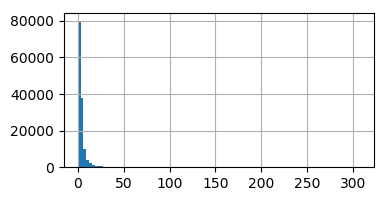

In [69]:
phecode = pd.read_csv(f"{DATA_DIR}/phecode1.2.tsv",sep="\t",dtype=str) # only for phecode 1.2
hpo = pd.read_csv(f"{DATA_DIR}/hpo.tsv",sep="\t",dtype=str)[['hpo_code','hpo_label','hpo_original']]
hpo = hpo[hpo['hpo_original']=='True'].reset_index().drop(['index','hpo_original'],axis=1)

phemap = pd.read_csv(f"{RAW_DATA_DIR}/PheMap_UMLS_Concepts_1.1.csv",dtype={'PHECODE':str})
phemap.columns = ['phecode1.2_code','CUI','PheMap_score']
_ = phemap['PheMap_score'].hist(bins=100,figsize=(4,2))
phemap['PheMap_score'].quantile(.95)
phemap['PheMap_score'].quantile(.99)

df = umls[['CUI','SAB','CODE']]
df = df[df['SAB'] == 'HPO'].drop('SAB',axis=1).drop_duplicates()
df.columns = ['CUI','hpo_code']
df['hpo_code'] = [x.replace(":","_") for x in df['hpo_code']]

phemap = phemap.merge(df) # Merge on CUI
phemap = phemap.merge(phecode).merge(hpo).sort_values('phecode1.2_code') # add labels from phecode1.2 and hpo
phemap = phemap[phemap['PheMap_score'] > 13.756688919771902] # keep only 95th percentile+

phemap = phemap[['phecode1.2_code','phecode1.2_label','phecode1.2_category','CUI','hpo_code','hpo_label','PheMap_score']]
phemap.to_csv(f'{DATA_DIR}/evidenceTables/PheMap_phecode1.2-hpo.tsv',sep="\t",index=False)


## Read in and combine evidence to form final maps

In [76]:
evidence_phecode12 = [
    'stringMatch_hpo-phecode1.2',
    'subStringMatch_hpo-to-phecode1.2',
    'subStringMatch_phecode1.2-to-hpo',
    'stringMatch_hpo-ICD9',
    'subStringMatch_hpo-to-ICD9',
    'subStringMatch_ICD9-to-hpo',
    'stringMatch_hpo-ICD10',
    'subStringMatch_hpo-to-ICD10',
    'subStringMatch_ICD10-to-hpo',
    'SORTA_phecode1.2-to-hpo',
    'SORTA_ICD9-to-hpo',
    'SORTA_ICD10-to-hpo',
    'PheMap_phecode1.2-hpo',
    'sharedUMLSCUI_ICD9-hpo',
    'sharedUMLSCUIplusRel_ICD9-hpo',
    'sharedUMLSCUI_ICD10-hpo',
    'sharedUMLSCUIplusRel_ICD10-hpo',
    'wikiMedMap_hpo-to-ICD9',
    'wikiMedMap_hpo-to-ICD10',
]

evidence_phecodeX = [
    'stringMatch_hpo-phecodeX',
    'subStringMatch_hpo-to-phecodeX',
    'subStringMatch_phecodeX-to-hpo',
    'stringMatch_hpo-ICD9',
    'subStringMatch_hpo-to-ICD9',
    'subStringMatch_ICD9-to-hpo',
    'stringMatch_hpo-ICD10',
    'subStringMatch_hpo-to-ICD10',
    'subStringMatch_ICD10-to-hpo',
    'SORTA_phecodeX-to-hpo',
    'SORTA_ICD9-to-hpo',
    'SORTA_ICD10-to-hpo',
    'sharedUMLSCUI_ICD9-hpo',
    'sharedUMLSCUIplusRel_ICD9-hpo',
    'sharedUMLSCUI_ICD10-hpo',
    'sharedUMLSCUIplusRel_ICD10-hpo',
    'wikiMedMap_hpo-to-ICD9',
    'wikiMedMap_hpo-to-ICD10',
]

In [72]:
phecode12 = pd.read_csv(f"{DATA_DIR}/phecode1.2.tsv",sep="\t",dtype=str)[['phecode1.2_code','phecode1.2_label','phecode1.2_category']]
phecodeX = pd.read_csv(f"{DATA_DIR}/phecodeX.tsv",sep="\t",dtype=str)[['phecodeX_code','phecodeX_label','phecodeX_category']]
hpo = pd.read_csv(f"{DATA_DIR}/hpo.tsv",sep="\t",dtype=str)[['hpo_code','hpo_label','hpo_original']]
hpo = hpo[hpo['hpo_original']=='True'].reset_index().drop(['index','hpo_original'],axis=1)

In [73]:
allLinks_phecode12 = pd.DataFrame(columns=['phecode1.2_code','hpo_code'])
for evidence in evidence_phecode12:
    df = pd.read_csv(f"../data/evidenceTables/{evidence}.tsv",sep="\t",dtype=str)

    if 'phecode1.2_codeList' not in df.columns: # Direct phecode evidence
        if any(['score' in x for x in df.columns]):
            score_col = [x for x in df.columns if 'score' in x][0]
            df[score_col] = [float(x) for x in df[score_col]]
            links = df[['phecode1.2_code','hpo_code', score_col]].drop_duplicates()
            links = links.groupby(['phecode1.2_code','hpo_code'])[[score_col]].max().reset_index()
            links = links.rename(columns={score_col:evidence})
        else:
            links = df[['phecode1.2_code','hpo_code']].drop_duplicates()
            links[evidence] = True
        allLinks_phecode12 = allLinks_phecode12.merge(links,how='outer')
    else: #phecode evidence through ICD codes
        df = df[df['phecode1.2_codeList'].notnull()] # remove rows with only phecodeX associations
        df['phecode1.2_codeList'] = [ast.literal_eval(x) for x in df['phecode1.2_codeList']]
        links = []
        if any(['score' in x for x in df.columns]):
            score_col = [x for x in df.columns if 'score' in x][0]
            df[score_col] = [float(x) for x in df[score_col]]
            for i,r in df.iterrows():
                links += [{'phecode1.2_code':code, 'hpo_code':r['hpo_code'], score_col:r[score_col]} for code in r['phecode1.2_codeList']]
            links = pd.DataFrame(links)
            links = links[['phecode1.2_code','hpo_code',score_col]].drop_duplicates()
            links = links.groupby(['phecode1.2_code','hpo_code'])[[score_col]].max().reset_index()
            links = links.rename(columns={score_col:evidence})
        else:
            for i,r in df.iterrows():
                links += [{'phecode1.2_code':code, 'hpo_code':r['hpo_code']} for code in r['phecode1.2_codeList']]
            links = pd.DataFrame(links).drop_duplicates()
            links[evidence] = True
        allLinks_phecode12 = allLinks_phecode12.merge(links,how='outer')
allLinks_phecode12 = allLinks_phecode12.merge(phecode12).merge(hpo)
allLinks_phecode12 = allLinks_phecode12[['phecode1.2_code', 'phecode1.2_label', 'phecode1.2_category','hpo_code', 'hpo_label'] + evidence_phecode12].sort_values('phecode1.2_code').reset_index().drop('index',axis=1)

allLinks_phecode12.to_csv("../data/finalHPO-phecodeLinks/hpo-phecode1.2_links.tsv",sep="\t",index=False)
allLinks_phecode12.head()

,phecode1.2_code,phecode1.2_label,phecode1.2_category,hpo_code,hpo_label,stringMatch_hpo-phecode1.2,subStringMatch_hpo-to-phecode1.2,subStringMatch_phecode1.2-to-hpo,stringMatch_hpo-ICD9,subStringMatch_hpo-to-ICD9,...,SORTA_phecode1.2-to-hpo,SORTA_ICD9-to-hpo,SORTA_ICD10-to-hpo,PheMap_phecode1.2-hpo,sharedUMLSCUI_ICD9-hpo,sharedUMLSCUIplusRel_ICD9-hpo,sharedUMLSCUI_ICD10-hpo,sharedUMLSCUIplusRel_ICD10-hpo,wikiMedMap_hpo-to-ICD9,wikiMedMap_hpo-to-ICD10
0,008,Intestinal infection,infectious diseases,HP_0033143,Jejunitis,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
1,008,Intestinal infection,infectious diseases,HP_0004387,Enterocolitis,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,008,Intestinal infection,infectious diseases,HP_0011024,Abnormality of the gastrointestinal tract,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
3,008,Intestinal infection,infectious diseases,HP_0200042,Skin ulcer,NaN,NaN,NaN,NaN,NaN,...,NaN,81.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,008,Intestinal infection,infectious diseases,HP_0100523,Liver abscess,NaN,NaN,NaN,NaN,NaN,...,NaN,84.85,84.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
allLinks_phecodeX = pd.DataFrame(columns=['phecodeX_code','hpo_code'])
for evidence in evidence_phecodeX:
    df = pd.read_csv(f"../data/evidenceTables/{evidence}.tsv",sep="\t",dtype=str)

    if 'phecodeX_codeList' not in df.columns: # Direct phecode evidence
        if any(['score' in x for x in df.columns]):
            score_col = [x for x in df.columns if 'score' in x][0]
            df[score_col] = [float(x) for x in df[score_col]]
            links = df[['phecodeX_code','hpo_code', score_col]].drop_duplicates()
            links = links.groupby(['phecodeX_code','hpo_code'])[[score_col]].max().reset_index()
            links = links.rename(columns={score_col:evidence})
        else:
            links = df[['phecodeX_code','hpo_code']].drop_duplicates()
            links[evidence] = True
        allLinks_phecodeX = allLinks_phecodeX.merge(links,how='outer')
    else: #phecode evidence through ICD codes
        df = df[df['phecodeX_codeList'].notnull()] # remove rows with only phecode1.2 associations
        df['phecodeX_codeList'] = [ast.literal_eval(x) for x in df['phecodeX_codeList']]
        links = []
        if any(['score' in x for x in df.columns]):
            score_col = [x for x in df.columns if 'score' in x][0]
            df[score_col] = [float(x) for x in df[score_col]]
            for i,r in df.iterrows():
                links += [{'phecodeX_code':code, 'hpo_code':r['hpo_code'], score_col:r[score_col]} for code in r['phecodeX_codeList']]
            links = pd.DataFrame(links)
            links = links[['phecodeX_code','hpo_code',score_col]].drop_duplicates()
            links = links.groupby(['phecodeX_code','hpo_code'])[[score_col]].max().reset_index()
            links = links.rename(columns={score_col:evidence})
        else:
            for i,r in df.iterrows():
                links += [{'phecodeX_code':code, 'hpo_code':r['hpo_code']} for code in r['phecodeX_codeList']]
            links = pd.DataFrame(links).drop_duplicates()
            links[evidence] = True
        allLinks_phecodeX = allLinks_phecodeX.merge(links,how='outer')
allLinks_phecodeX = allLinks_phecodeX.merge(phecodeX).merge(hpo) #! drop 2 codes with weirdness/missingness in phecodeX: 370.42, N293
allLinks_phecodeX = allLinks_phecodeX[['phecodeX_code', 'phecodeX_label', 'phecodeX_category','hpo_code', 'hpo_label'] + evidence_phecodeX].sort_values('phecodeX_code').reset_index().drop('index',axis=1)

allLinks_phecodeX.to_csv("../data/finalHPO-phecodeLinks/hpo-phecodeX_links.tsv",sep="\t",index=False)
allLinks_phecodeX.head()


,phecodeX_code,phecodeX_label,phecodeX_category,hpo_code,hpo_label,stringMatch_hpo-phecodeX,subStringMatch_hpo-to-phecodeX,subStringMatch_phecodeX-to-hpo,stringMatch_hpo-ICD9,subStringMatch_hpo-to-ICD9,...,subStringMatch_ICD10-to-hpo,SORTA_phecodeX-to-hpo,SORTA_ICD9-to-hpo,SORTA_ICD10-to-hpo,sharedUMLSCUI_ICD9-hpo,sharedUMLSCUIplusRel_ICD9-hpo,sharedUMLSCUI_ICD10-hpo,sharedUMLSCUIplusRel_ICD10-hpo,wikiMedMap_hpo-to-ICD9,wikiMedMap_hpo-to-ICD10
0,001,Salmonella,ID,HP_0033143,Jejunitis,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,001,Salmonella,ID,HP_0005661,Salmonella osteomyelitis,NaN,NaN,NaN,True,True,...,True,NaN,100.00,100.00,True,True,True,True,NaN,NaN
2,002,Staphylococcus,ID,HP_0000951,Abnormality of the skin,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
3,002,Staphylococcus,ID,HP_0032326,Methicillin-resistant Staphylococcus aureus in...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,81.25,93.88,NaN,NaN,True,True,NaN,NaN
4,002,Staphylococcus,ID,HP_0100658,Cellulitis,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN


### Maps annotated by categories of evidence

In [78]:
allLinks_phecode12 = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecode1.2_links.tsv",sep="\t",dtype={'phecode1.2_code':str})
allLinks_phecodeX = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecodeX_links.tsv",sep="\t",dtype={'phecodeX_code':str})

In [79]:
def levelsOfEvidence(allLinks, evidence, phecode_str):
    allLinks['StrongEvidenceSpecific'] = (allLinks[f'stringMatch_hpo-{phecode_str}'].notnull() |
                                             allLinks[f'subStringMatch_hpo-to-{phecode_str}'].notnull()|
                                             allLinks[f'subStringMatch_{phecode_str}-to-hpo'].notnull() |
                                              (allLinks[f'SORTA_{phecode_str}-to-hpo']== 100))
    if phecode_str == 'phecode1.2':
        allLinks['StrongEvidenceSpecific'] = (allLinks['StrongEvidenceSpecific'] |
                                               (allLinks[f'PheMap_{phecode_str}-hpo'] >= 43.21934845055406))
        
    allLinks['StrongEvidenceSpecific'] = [True if x else  np.nan for x in allLinks['StrongEvidenceSpecific']]

    allLinks['StrongEvidenceBroad'] = (allLinks[f'stringMatch_hpo-{phecode_str}'].notnull() |
                                              allLinks[f'subStringMatch_hpo-to-{phecode_str}'].notnull() | 
                                              allLinks[f'subStringMatch_{phecode_str}-to-hpo'].notnull() | 
                                              allLinks['stringMatch_hpo-ICD9'].notnull() |
                                              allLinks['stringMatch_hpo-ICD10'].notnull() |
                                              allLinks['sharedUMLSCUI_ICD9-hpo'].notnull() | 
                                              allLinks['sharedUMLSCUI_ICD10-hpo'].notnull() | 
                                              (allLinks[f'SORTA_{phecode_str}-to-hpo']== 100) |
                                              (allLinks['SORTA_ICD9-to-hpo']== 100) |
                                              (allLinks['SORTA_ICD10-to-hpo']== 100) )
    if phecode_str == 'phecode1.2':
        allLinks['StrongEvidenceBroad'] = (allLinks['StrongEvidenceBroad'] |
                                               (allLinks[f'PheMap_{phecode_str}-hpo'] >= 43.21934845055406))
        
    allLinks['StrongEvidenceBroad'] = [True if x else  np.nan for x in allLinks['StrongEvidenceBroad']]

    allLinks['AnyEvidence'] = [True if x else  np.nan for x in allLinks[evidence].notnull().any(axis=1)]

    return allLinks

In [80]:
allLinks_evidenceRating = levelsOfEvidence(allLinks_phecode12, evidence_phecode12, 'phecode1.2')
allLinks_evidenceRating.to_csv("../data/finalHPO-phecodeLinks/hpo-phecode1.2_links_withEvidenceRatings.tsv",sep="\t",index=False)

allLinks_evidenceRating = levelsOfEvidence(allLinks_phecodeX, evidence_phecodeX, 'phecodeX')
allLinks_evidenceRating.to_csv("../data/finalHPO-phecodeLinks/hpo-phecodeX_links_withEvidenceRatings.tsv",sep="\t",index=False)

### Maps with all children of HPO terms

In [174]:
allLinks_phecode12 = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecode1.2_links.tsv",sep="\t",dtype={'phecode1.2_code':str})
allLinks_phecodeX = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecodeX_links.tsv",sep="\t",dtype={'phecodeX_code':str})

phecode12 = pd.read_csv(f"{DATA_DIR}/phecode1.2.tsv",sep="\t",dtype=str)[['phecode1.2_code','phecode1.2_label','phecode1.2_category']]
phecodeX = pd.read_csv(f"{DATA_DIR}/phecodeX.tsv",sep="\t",dtype=str)[['phecodeX_code','phecodeX_label','phecodeX_category']]
hpo = pd.read_csv(f"{DATA_DIR}/hpo.tsv",sep="\t",dtype=str)[['hpo_code','hpo_label','hpo_original']]
hpo = hpo[hpo['hpo_original']=='True'].reset_index().drop(['index','hpo_original'],axis=1)

In [176]:
def expandToChildren(allLinks, evidence, phecode_str):
    allLinks_children = []
    for i,r in allLinks.iterrows():
        if i % 500 == 0:
            print(i)
        try:
            term = Ontology.get_hpo_object(r['hpo_code'].replace('_',":"))
        except:
            try:
                term = Ontology.get_hpo_object(r['hpo_label'])
                print(f"Used term name for {r['hpo_code']} {r['hpo_label']}. New term: {term.id} {term.name}")
            except:
                print(f"Failed {r['hpo_code']} {r['hpo_label']}")
                
        children = []
        _ = recursiveChildFinder(term.children,children)
        allLinks_children.append({**r.drop(['hpo_label',f'{phecode_str}_label',f'{phecode_str}_category']),**{'hpo_child':False}})
        if (len(set(children)) < 100):
            for child in set(children):
                allLinks_children.append({**r.drop(['hpo_label','hpo_code',f'{phecode_str}_label',f'{phecode_str}_category']),**{'hpo_code':child.replace(":","_"),'hpo_child':True}})

    allLinks_children = pd.DataFrame(allLinks_children)
    allLinks_children = allLinks_children.groupby([f'{phecode_str}_code','hpo_code']).max().reset_index().merge(hpo) # Take the maximal evidence for each child link

    if phecode_str == 'phecode1.2':
        allLinks_children = allLinks_children.merge(phecode12)
    elif phecode_str == 'phecodeX':
        allLinks_children = allLinks_children.merge(phecodeX)
        
    return allLinks_children[[f'{phecode_str}_code', f'{phecode_str}_label', f'{phecode_str}_category',
         'hpo_code', 'hpo_label', 'hpo_child'] + evidence]

In [177]:
allLinks_children = expandToChildren(allLinks_phecode12, evidence_phecode12, 'phecode1.2')
allLinks_children = levelsOfEvidence(allLinks_children, evidence_phecode12, 'phecode1.2')
allLinks_children.to_csv("../data/finalHPO-phecodeLinks/hpo-phecode1.2_links_withHPOchildrenExpansion.tsv",sep="\t",index=False)

allLinks_children = expandToChildren(allLinks_phecodeX, evidence_phecodeX, 'phecodeX')
allLinks_children = levelsOfEvidence(allLinks_children, evidence_phecodeX, 'phecodeX')
allLinks_children.to_csv("../data/finalHPO-phecodeLinks/hpo-phecodeX_links_withHPOchildrenExpansion.tsv",sep="\t",index=False)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500


In [179]:
allLinks_children_phecode12 = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecode1.2_links_withHPOchildrenExpansion.tsv",sep="\t",dtype={'phecode1.2_code':str})
allLinks_children_phecodeX = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecodeX_links_withHPOchildrenExpansion.tsv",sep="\t",dtype={'phecodeX_code':str})

In [182]:
len(allLinks_children_phecode12['hpo_code'].unique())

7936

In [183]:
# Codes identified uniquely by children
sum(allLinks_children_phecode12['hpo_child'])
children = allLinks_children_phecode12[allLinks_children_phecode12['hpo_child']]['hpo_code'].unique()
notChildren = allLinks_children_phecode12[~allLinks_children_phecode12['hpo_child']]['hpo_code'].unique()
len(set([x for x in children if x not in notChildren]))


sum(allLinks_children_phecodeX['hpo_child'])
children = allLinks_children_phecodeX[allLinks_children_phecodeX['hpo_child']]['hpo_code'].unique()
notChildren = allLinks_children_phecodeX[~allLinks_children_phecodeX['hpo_child']]['hpo_code'].unique()
len([x for x in children if x not in notChildren])

31592

5571

36237

5364

## Manually linked

In [130]:
manual_links = pd.read_csv(f"{RAW_DATA_DIR}/4-22-22mapsR_package_HPO_anno_view_for_Evonne.csv",dtype={'jd_code':str})[['HPO_ID','jd_code']]
manual_links.columns = ['hpo_code','phecode1.2_code']
manual_links = manual_links[manual_links['phecode1.2_code'].notnull()].drop_duplicates()
manual_links['hpo_code'] = [x.replace(":","_") for x in manual_links['hpo_code']]
manual_links.to_csv(f"{DATA_DIR}/manualReview/hpo-phecode1.2-links_manuallyLinked.tsv",sep="\t",index=False)
len(manual_links)

4200

In [128]:
manual_links = pd.read_csv(f"{RAW_DATA_DIR}/4-13-22mapsR_package_HPO_anno_phecodeX_view_for_Evonne.csv",dtype={'jd_code':str})[['HPO_ID','jd_code']]
manual_links.columns = ['hpo_code','phecodeX_code']
manual_links = manual_links[manual_links['phecodeX_code'].notnull()].drop_duplicates()
manual_links['hpo_code'] = [x.replace(":","_") for x in manual_links['hpo_code']]
manual_links.to_csv(f"{DATA_DIR}/manualReview/hpo-phecodeX-links_manuallyLinked.tsv",sep="\t",index=False)
len(manual_links)

4222

## For manual review

In [146]:
allLinks_phecode12 = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecode1.2_links.tsv",sep="\t",dtype={'phecode1.2_code':str})
manual_forReview = allLinks_phecode12.copy(deep=True)
manual_forReview = manual_forReview.iloc[np.random.permutation(len(manual_forReview))][['phecode1.2_label','hpo_label','phecode1.2_code','hpo_code']]
#manual_forReview.to_csv("../data/manualReview/hpo-phecode1.2-links_forManualReview.tsv",sep="\t",index=False)

In [154]:
allLinks_phecodeX = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecodeX_links.tsv",sep="\t",dtype={'phecodeX_code':str})
manual_forReview = allLinks_phecodeX.copy(deep=True)
manual_forReview = manual_forReview.iloc[np.random.permutation(len(manual_forReview))][['phecodeX_label','hpo_label','phecodeX_code','hpo_code']]
#manual_forReview.to_csv("../data/manualReview/hpo-phecodeX-links_forManualReview.tsv",sep="\t",index=False)

In [155]:
allLinks_children_phecode12 = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecode1.2_links_withHPOchildrenExpansion.tsv",sep="\t",dtype={'phecode1.2_code':str})
manual_forReview = allLinks_children_phecode12.copy(deep=True)
manual_forReview = manual_forReview.iloc[np.random.permutation(len(manual_forReview))][['phecode1.2_label','hpo_label','phecode1.2_code','hpo_code']]
#manual_forReview.to_csv("../data/manualReview/hpo-phecode1.2-links_withHPOchildrenExpansion_forManualReview.tsv",sep="\t",index=False)

In [160]:
allLinks_children_phecodeX = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecodeX_links_withHPOchildrenExpansion.tsv",sep="\t",dtype={'phecode1.2_code':str})
manual_forReview = allLinks_children_phecodeX.copy(deep=True)
manual_forReview = manual_forReview.iloc[np.random.permutation(len(manual_forReview))][['phecodeX_label','hpo_label','phecodeX_code','hpo_code']]
#manual_forReview.to_csv("../data/manualReview/hpo-phecodeX-links_withHPOchildrenExpansion_forManualReview.tsv",sep="\t",index=False)

## Filtered and formatted maps

In [2]:
allLinks_phecode12 = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecode1.2_links_withEvidenceRatings.tsv",sep="\t",dtype={'phecode1.2_code':str})
allLinks_phecodeX = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecodeX_links_withEvidenceRatings.tsv",sep="\t",dtype={'phecodeX_code':str})
allLinks_children_phecode12 = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecode1.2_links_withHPOchildrenExpansion.tsv",sep="\t",dtype={'phecode1.2_code':str})
allLinks_children_phecodeX = pd.read_csv("../data/finalHPO-phecodeLinks/hpo-phecodeX_links_withHPOchildrenExpansion.tsv",sep="\t",dtype={'phecodeX_code':str})

### Filtered

In [17]:
def strongEvidenceFilter(df, out, label):
    dfspec = df[df['StrongEvidenceSpecific'].notnull()]
    dfspec.to_csv(f"{out}_StrongEvidenceSpecific.tsv",sep="\t",index=False)
    dfbroad = df[df['StrongEvidenceBroad'].notnull()]
    dfbroad.to_csv(f"{out}_StrongEvidenceBroad.tsv",sep="\t",index=False)
    return dfspec, dfbroad

In [18]:
allLinks_phecode12_spec, allLinks_phecode12_broad = strongEvidenceFilter(allLinks_phecode12.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/hpo-phecode1.2_links","1.2")
allLinks_phecodeX_spec, allLinks_phecodeX_broad = strongEvidenceFilter(allLinks_phecodeX.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/hpo-phecodeX_links","X")
allLinks_children_phecode12_spec, allLinks_children_phecode12_broad = strongEvidenceFilter(allLinks_children_phecode12.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/hpo-phecode1.2_linkswithHPOchildrenExpansion","1.2")
allLinks_children_phecodeX_spec, allLinks_children_phecodeX_broad = strongEvidenceFilter(allLinks_children_phecodeX.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/hpo-phecodeX_linkswithHPOchildrenExpansion","X")

### Format for PheRS

In [ ]:
# PheRS format
#  hpo_term_id                      hpo_term_name phecode                                  phecode_name
#    1:  HP:0000003       Multicystic kidney dysplasia   586.2                      Cyst of kidney, acquired
#    2:  HP:0000010 Recurrent urinary tract infections     591                       Urinary tract infection

In [13]:
def formatForPheRS(df,out,label):
    df = df[['hpo_code','hpo_label',f'phecode{label}_code',f'phecode{label}_label']]
    df['hpo_code'] = [x.replace("_",":") for x in df['hpo_code']]
    df.columns = ['hpo_term_id','hpo_term_name','phecode','phecode_name']
    df.to_csv(f"{out}_PheRS.tsv",sep="\t",index=False)

In [14]:
formatForPheRS(allLinks_phecode12.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecode1.2_links","1.2")
formatForPheRS(allLinks_phecodeX.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecodeX_links","X")
formatForPheRS(allLinks_children_phecode12.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecode1.2_linkswithHPOchildrenExpansion","1.2")
formatForPheRS(allLinks_children_phecodeX.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecodeX_linkswithHPOchildrenExpansion","X")

/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# PheRS formatted maps for filtered sets

formatForPheRS(allLinks_phecode12_spec.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecode1.2_links_StrongEvidenceSpecific","1.2")
formatForPheRS(allLinks_phecodeX_spec.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecodeX_links_StrongEvidenceSpecific","X")
formatForPheRS(allLinks_children_phecode12_spec.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecode1.2_linkswithHPOchildrenExpansion_StrongEvidenceSpecific","1.2")
formatForPheRS(allLinks_children_phecodeX_spec.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecodeX_linkswithHPOchildrenExpansion_StrongEvidenceSpecific","X")

formatForPheRS(allLinks_phecode12_broad.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecode1.2_links_StrongEvidenceBroad","1.2")
formatForPheRS(allLinks_phecodeX_broad.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecodeX_links_StrongEvidenceBroad","X")
formatForPheRS(allLinks_children_phecode12_broad.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecode1.2_linkswithHPOchildrenExpansion_StrongEvidenceBroad","1.2")
formatForPheRS(allLinks_children_phecodeX_broad.copy(deep=True),"../data/finalHPO-phecodeLinks/mapsFilteredByEvidenceType/pheRSpackage/hpo-phecodeX_linkswithHPOchildrenExpansion_StrongEvidenceBroad","X")

/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# To do:
# Maps with only the top 1:1 HPO-Phecode mapping
# Maybe arranged by how specific/precise the evidence is:
# stringMatch_hpo-phecodeX
# subStringMatch_hpo-to-phecodeX
# subStringMatch_phecodeX-to-hpo
# stringMatch_hpo-ICD9
# SORTA_phecodeX-to-hpo
# subStringMatch_ICD9-to-hpo
# subStringMatch_ICD10-to-hpo
# stringMatch_hpo-ICD10
# subStringMatch_hpo-to-ICD10
# subStringMatch_hpo-to-ICD9
# SORTA_ICD10-to-hpo
# SORTA_ICD9-to-hpo
# wikiMedMap_hpo-to-ICD9
# sharedUMLSCUIplusRel_ICD9-hpo
# wikiMedMap_hpo-to-ICD10
# sharedUMLSCUIplusRel_ICD10-hpo
# PheMap